In [1]:
import torch
import matplotlib.pyplot as plt

from models.wta_cnp import WTA_CNP
from data.data_generators import *

if torch.cuda.is_available():
    device = torch.device("cuda:0")
else:
    device = torch.device("cpu")
device = torch.device("cpu")

In [2]:
# Hyperparameters
batch_size = 1
n_max_obs, n_max_tar = 10, 10

t_steps = 200
num_demos = 1
num_classes = 1
num_indiv = num_demos//num_classes  # number of demos per class
noise_clip = 0.0
dx, dy = 1, 1

num_val = 1
num_val_indiv = num_val//num_classes

colors = ['r', 'g', 'b', 'm']

In [3]:
from IPython import get_ipython
ip = get_ipython()
if ip is None:
    ip = False
else:
    ip = True

X: torch.Size([1, 200, 1]) Y: torch.Size([1, 200, 1]) VX: torch.Size([1, 200, 1]) VY: torch.Size([1, 200, 1])


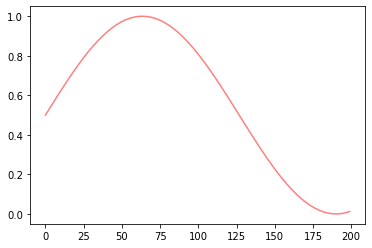

In [4]:
# Data generation
import matplotlib.pyplot as plt

if not ip:
    plt.switch_backend('agg')

x = torch.linspace(0, 1, 200).repeat(num_indiv, 1)
y = torch.zeros(num_demos, t_steps, dy)

vx = torch.linspace(0, 1, 200).repeat(num_val_indiv, 1)
vy = torch.zeros(num_val, t_steps, dy)

for i in range(num_classes):
    start_ind = i*num_indiv
    coeff = (i+1)/2*torch.pi
    y[start_ind:start_ind+num_indiv] = (torch.unsqueeze(generate_sin(x*coeff), 2) +1)/2.0

    noise = torch.unsqueeze(torch.clamp(torch.randn(x.shape)*1e-4**0.5, min=0) - noise_clip, -1)

    start_ind = i*num_val_indiv
    vy[start_ind:start_ind+num_indiv] = y[start_ind:start_ind+num_indiv].clone() + noise  # num_indiv = num_val_indiv

x = torch.unsqueeze(x.repeat(num_classes, 1), 2)  # since dx = 1
vx = torch.unsqueeze(vx.repeat(num_classes, 1), 2)
print("X:", x.shape, "Y:", y.shape, "VX:", vx.shape, "VY:", vy.shape)

if ip:
    for i, y_i in enumerate(y):
        plt.plot(y_i, alpha=0.5, c=colors[i%num_classes])

In [5]:
def get_batch(x, y, traj_ids):
    n_t = torch.randint(1, n_max_tar, (1,)).item()
    n_o = torch.randint(1, n_max_obs, (1,)).item()

    obs = torch.zeros(batch_size, n_o, dx+dy, device=device)
    tar = torch.zeros(batch_size, n_t, dx, device=device)
    tar_val = torch.zeros(batch_size, n_t, dy, device=device)

    for i in range(len(traj_ids)):
        random_query_ids = torch.randperm(t_steps)
        o_ids = random_query_ids[:n_o]
        t_ids = random_query_ids[n_o:n_o+n_t]

        obs[i, :, :] = torch.cat((x[traj_ids[i], o_ids], y[traj_ids[i], o_ids]), dim=-1)
        tar[i, :, :] = x[traj_ids[i], t_ids]
        tar_val[i, :, :] = y[traj_ids[i], t_ids]

    # print("Obs:", obs.shape, "Tar:", tar.shape, "Tar_val:", tar_val.shape)
    return obs, tar, tar_val

def get_validation_batch(vx, vy, traj_ids, device=device):
    num_obs = torch.randint(1, n_max_obs, (1,)).item()

    obs = torch.zeros(batch_size, num_obs, dx+dy, device=device)
    tar = torch.zeros(batch_size, t_steps, dx, device=device)
    tar_val = torch.zeros(batch_size, t_steps, dy, device=device)

    for i in range(len(traj_ids)):
        random_query_ids = torch.randperm(t_steps)
        o_ids = random_query_ids[:num_obs]

        obs[i, :, :] = torch.cat((vx[traj_ids[i], o_ids], vy[traj_ids[i], o_ids]), dim=-1)
        tar[i, :, :] = vx[traj_ids[i]]
        tar_val[i, :, :] = vy[traj_ids[i]]

    return obs, tar, tar_val

In [6]:
model = WTA_CNP(1, 1, n_max_obs, n_max_tar, [128, 128, 128], 1, [128, 128, 128], 1, scale_coefs=True).to(device)
optimizer = torch.optim.Adam(lr=1e-4, params=model.parameters())

print(sum(p.numel() for p in model.parameters()))

66947


In [7]:
from matplotlib.lines import Line2D

def draw_val_plot(root_folder, epoch):
    plt_y_lim_up = (torch.max(vy) + 0.1).item()
    plt_y_lim_down = (torch.min(vy) - 0.1).item()

    obs = torch.zeros((batch_size, 1, 1, 2)).to(device)
    for i in range(batch_size):
        obs[i] = torch.Tensor([x[i, 80, 0], y[i, 80, 0]]).unsqueeze(0).unsqueeze(0).to(device)

    tar = torch.linspace(0, 1, 200).unsqueeze(0).unsqueeze(-1).to(device)

    with torch.no_grad():
        for i in range(batch_size):
            pred_wta, gate = model(obs[i], tar)

            plt.ylim((plt_y_lim_down, plt_y_lim_up))
            plt.scatter(obs[i,:,:,0].cpu(), obs[i,:,:,1].cpu(), c='k')

            handles = []
            for j in range(model.num_decoders):
                plt.plot(torch.linspace(0, 1, 200), pred_wta[j,0,:,0].cpu(), colors[j], alpha=max(0.2, gate[0, 0, j].item()))  # wta pred
                handles.append(Line2D([0], [0], label=f'gate{j}: {gate[0, 0, j].item():.4f}', color=colors[j]))
            
            for j in range(batch_size):
                plt.plot(torch.linspace(0, 1, 200), vy[j].squeeze(-1).cpu(), 'k', alpha=0.05 if j!=i else 0.35)  # data

            plt.legend(handles=handles, loc='upper right')

            plt.savefig(f'{root_folder}img/{i}_{epoch}.png')
            plt.close()

In [9]:
import time
import os

timestamp = int(time.time())
root_folder = f'outputs/tests/{str(timestamp)}/'

if not os.path.exists(root_folder):
    os.makedirs(root_folder)

if not os.path.exists(f'{root_folder}saved_models/'):
    os.makedirs(f'{root_folder}saved_models/')

if not os.path.exists(f'{root_folder}img/'):
    os.makedirs(f'{root_folder}img/')

torch.save(y, f'{root_folder}y.pt')

epochs = 1_000_000
epoch_iter = num_demos//batch_size  # number of batches per epoch (e.g. 100//32 = 3)
v_epoch_iter = num_val//batch_size  # number of batches per validation (e.g. 100//32 = 3)
avg_loss = 0

val_per_epoch = 1000
min_val_error = 1000000

mse_loss = torch.nn.MSELoss()

training_loss, validation_error = [], []
tr_loss_path = f'{root_folder}training_loss.pt'
val_err_path = f'{root_folder}validation_error.pt'

for epoch in range(epochs):
    epoch_loss = 0

    traj_ids = torch.randperm(x.shape[0])[:batch_size*epoch_iter].chunk(epoch_iter)  # [:batch_size*epoch_iter] because nof_trajectories may be indivisible by batch_size

    for i in range(epoch_iter):
        optimizer.zero_grad()
        obs, tar_x, tar_y = get_batch(x, y, traj_ids[i])
        pred, gate = model(obs, tar_x)
        loss, nll = model.loss(pred, gate, tar_y)
        loss.backward()
        optimizer.step()

        epoch_loss += nll.item()

    training_loss.append(epoch_loss)

    if epoch % val_per_epoch == 0:
        with torch.no_grad():
            v_traj_ids = torch.randperm(vx.shape[0])[:batch_size*v_epoch_iter].chunk(v_epoch_iter)
            val_epoch_err = 0

            for j in range(v_epoch_iter):
                o, t, tr = get_validation_batch(vx, vy, v_traj_ids[j])
                p, g = model(o, t)
                dec_id = torch.argmax(g.squeeze(1), dim=-1)
                vp_means = p[dec_id, torch.arange(batch_size), :, :dy]
                val_epoch_err += mse_loss(vp_means, tr).item()

            validation_error.append(val_epoch_err)

            if val_epoch_err < min_val_error:
                min_val_error = val_epoch_err
                print(f'New best: {min_val_error}')
                torch.save(model.state_dict(), f'{root_folder}saved_models/best.pt')

        if epoch % (val_per_epoch*10) == 0:
            draw_val_plot(root_folder, epoch)

    avg_loss += epoch_loss

    if epoch % 100 == 0:
        print("Epoch: {}, Loss: {}".format(epoch, avg_loss/100))
        avg_loss = 0

    if epoch % 100000:
        torch.save(torch.Tensor(training_loss), tr_loss_path)
        torch.save(torch.Tensor(validation_error), val_err_path)


tensor(1., grad_fn=<SqueezeBackward1>)


IndexError: tuple index out of range

In [ ]:
# def get_validation_batch(o_ids=[0, -120]):
#     obs = torch.cat((vx[:, o_ids, :], vy[:, o_ids, :]), dim=-1)
#     tar = vx[:, torch.arange(t_steps)]
#     tar_val= vy[:, torch.arange(t_steps)]

#     return obs, tar, tar_val

def get_validation_batch(traj_ids=[0,1,2,3], o_ids=[15]):
    obs = torch.cat((vx[traj_ids, o_ids, :].cpu(), vy[traj_ids, o_ids, :].cpu()), dim=-1).unsqueeze(1)
    tar = torch.index_select(vx.cpu(), 0, torch.tensor(traj_ids))
    tar_val= torch.index_select(vy.cpu(), 0, torch.tensor(traj_ids))

    return obs, tar, tar_val

def generate_test_batch(n=4):
    obs = torch.zeros(n, 2, 2)
    obs[0] = torch.tensor([[0, 0], [1, 0]])
    obs[1] = torch.tensor([[0, 0], [1, 1]])
    obs[2] = torch.tensor([[0, 1], [1, 0]])
    obs[3] = torch.tensor([[0, 1], [1, 1]])
    tar = vx[:4, torch.arange(t_steps)]

    return obs, tar

torch.Size([4, 1, 2]) torch.Size([4, 200, 1]) torch.Size([4, 200, 1])
tensor([[0.2500, 0.2498, 0.2501, 0.2501]])


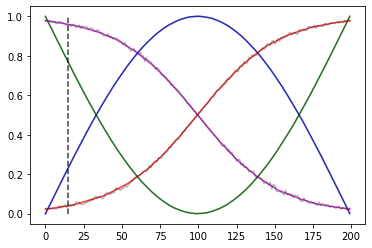

In [ ]:
file_name = '/home/yigit/projects/mbcnp/outputs/combined/1692112657/'

test_batch_size = 4

# Testing the best model
model = WTA_CNP(1, 1, 6, 6, [128, 128, 128], 4, [128, 128, 128], test_batch_size)
model.load_state_dict(torch.load(f'{file_name}saved_models/best.pt'))
model.eval()

ids=[15]

o, t, tr = get_validation_batch(o_ids=ids)
print(o.shape, t.shape, tr.shape)

with torch.no_grad():
    if next(model.parameters()).is_cuda:
        p, g = model(o, t)
    else:
        p, g = model(o.cpu(), t.cpu())

p, g = p.cpu().numpy(), g.cpu()
t, tr = t.cpu().numpy(), tr.cpu().numpy()

for i in range(test_batch_size):
    dec_id = torch.argmax(g[i, :, :]).item()
    plt.plot(range(t_steps), p[dec_id, i, :, 0], colors[dec_id], alpha=0.75)
    plt.plot(range(t_steps), tr[i, :, 0], 'k', alpha=0.3)

for i in range(len(ids)):
    plt.plot([ids[i]]*t_steps, torch.linspace(0, 1, t_steps), 'k--', alpha=0.75)

print(g.mean(dim=0))

torch.Size([4, 1, 2]) torch.Size([4, 200, 1]) torch.Size([4, 200, 1])
tensor([[0.2500, 0.2032, 0.2968, 0.2500]])


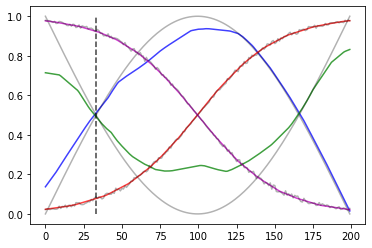

In [ ]:
ids=[33]

o, t, tr = get_validation_batch(o_ids=ids)
print(o.shape, t.shape, tr.shape)

with torch.no_grad():
    if next(model.parameters()).is_cuda:
        p, g = model(o, t)
    else:
        p, g = model(o.cpu(), t.cpu())

p, g = p.cpu().numpy(), g.cpu()
t, tr = t.cpu().numpy(), tr.cpu().numpy()

for i in range(test_batch_size):
    dec_id = torch.argmax(g[i, :, :]).item()
    plt.plot(range(t_steps), p[dec_id, i, :, 0], colors[dec_id], alpha=0.75)
    plt.plot(range(t_steps), tr[i, :, 0], 'k', alpha=0.3)

for i in range(len(ids)):
    plt.plot([ids[i]]*t_steps, torch.linspace(0, 1, t_steps), 'k--', alpha=0.75)

print(g.mean(dim=0))

torch.Size([4, 1, 2]) torch.Size([4, 200, 1]) torch.Size([4, 200, 1])
tensor([[0.4817, 0.0183, 0.0719, 0.4281]])


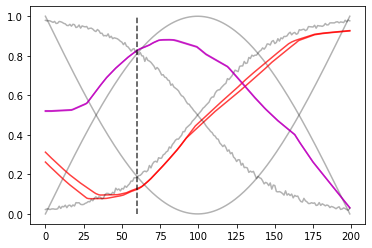

In [ ]:
ids=[60]

o, t, tr = get_validation_batch(o_ids=ids)
print(o.shape, t.shape, tr.shape)

with torch.no_grad():
    if next(model.parameters()).is_cuda:
        p, g = model(o, t)
    else:
        p, g = model(o.cpu(), t.cpu())

p, g = p.cpu().numpy(), g.cpu()
t, tr = t.cpu().numpy(), tr.cpu().numpy()

for i in range(test_batch_size):
    dec_id = torch.argmax(g[i, :, :]).item()
    plt.plot(range(t_steps), p[dec_id, i, :, 0], colors[dec_id], alpha=0.75)
    plt.plot(range(t_steps), tr[i, :, 0], 'k', alpha=0.3)

for i in range(len(ids)):
    plt.plot([ids[i]]*t_steps, torch.linspace(0, 1, t_steps), 'k--', alpha=0.75)

print(g.mean(dim=0))

In [ ]:
# model = WTA_CNP(1, 1, 10, 10, [128, 128, 128], 4, [128, 128, 128], 4)
# model.load_state_dict(torch.load(f'saved_models/wtacnp_synth_{file_name}.pt'))
# model.eval()

# o, t = generate_test_batch()

# print(o)

# with torch.no_grad():
#     p, g = model(o.cpu(), t.cpu())

# p, g = p.cpu().numpy(), g.cpu()

# for i in range(4):

#     print(o[i, 0, 0], o[i, 0, 1], o[i, 1, 0], o[i, 1, 1])

#     dec_id = torch.argmax(g[i, :, :]).item()
#     plt.plot(range(t_steps), p[dec_id, i, :, 0], colors[dec_id], alpha=0.7)

#     plt.scatter(o[i, 0, 0]*200, o[i, 0, 1], color='k', marker='x')
#     plt.scatter(o[i, 1, 0]*200, o[i, 1, 1], color='k', marker='x')

# for i in range(32):
#     plt.plot(range(t_steps), tr[i, :, 0], 'k', alpha=0.1, linestyle='dashed')

# plt.show()

RuntimeError: Error(s) in loading state_dict for WTA_CNP:
	size mismatch for encoder.2.weight: copying a param with shape torch.Size([256, 128]) from checkpoint, the shape in current model is torch.Size([128, 128]).
	size mismatch for encoder.2.bias: copying a param with shape torch.Size([256]) from checkpoint, the shape in current model is torch.Size([128]).
	size mismatch for encoder.4.weight: copying a param with shape torch.Size([128, 256]) from checkpoint, the shape in current model is torch.Size([128, 128]).